# Assignment 4

In this assignment, you will build a model to predict length of stay of 3 days or more  (as a binary classification outcome) using a sample from the Texas hospital discharge dataset. We will evaluate your model performance using a hold-out dataset that is kept from you.

In this assignment, you will generate a full analysis report, including the descriptive stats and missingness patterns, train and evaluate the model, indicate the optimal hyperparameters, explain the model, and evaluate fairness on `sex`.

Some instructions of this assignment:

1. You should use this checklist for reporting (and complete the checklist and include it as part of the submission):
[Journal of Medical Internet Research - Consolidated Reporting Guidelines for Prognostic and Diagnostic Machine Learning Modeling Studies: Development and Validation (jmir.org)](https://www.jmir.org/2023/1/e48763)

2. You can choose which modeling technique you want to use or come up with an ensemble if you want. It is up to you. You can try and compare different models.

3. In most publications you need to explain why you did not use a simpler modeling technique, so you should have an logistic regression model as a baseline to compare against.

4. You should submit the workbook, the checklist, and the model (see details below). For submission, __only submit your best model__. 

5. We have 10 bonus points to distribute among the class based on a ranking of how well your model predicts on the holdout. Bonus points 4,3,2,1 for the top four.

## Load useful packages

In [65]:
library(sdgm)
library(dplyr)
library(ggplot2)

## Load the data

In [66]:
# check the help file of this dataset. It documents the binary prediction model 
# that can be trained from this dataset.
?sdgm::texas

texas {sdgm},R Documentation


In [67]:
# In this assignment, we will provide the data pre-processing steps. Please don't change code here.

# get the dataset
df<-sdgm::getdata("texas")

# create binary outcome
df$status <- ifelse(as.numeric(df$LENGTH_OF_STAY) >= 3, 1, 0)

# Sample 10,000 observations
set.seed(123)  # Set seed for reproducibility
df <- df %>% sample_n(500)

# transform numeric predictors
df$age  <- as.numeric(df$PAT_AGE)
df$fees <- ifelse(df$CHRGS_NON_COV < 0, NA, df$CHRGS_NON_COV)


# transform categorical predictors
df$sex            <- as.factor(ifelse(df$SEX_CODE == "F", "F",
                                      ifelse(df$SEX_CODE == "M", "M", NA)))
df$ethnicity      <- as.factor(ifelse(df$ETHNICITY == "1" | df$ETHNICITY == "1.0", 1,
                                        ifelse(df$ETHNICITY == "2" | df$ETHNICITY == "2.0", 2, NA)))
df$race           <- as.factor(df$RACE)
df$location       <- as.factor(df$PAT_STATE)
df$weekday        <- as.factor(gsub("'",'',df$ADMIT_WEEKDAY))
df$risk_mortality <- as.factor(gsub("'",'',df$RISK_MORTALITY))
df$severity       <- as.factor(gsub("'",'',df$ILLNESS_SEVERITY))
df$drg            <- as.factor(gsub("'",'',df$APR_DRG))

# select predictors
vars_select <- c("status", "age", "fees", "sex", "ethnicity", "race", "weekday",
                         "location", "risk_mortality", "severity", "drg")

# transform from tibble to dataframe
full_data <- as.data.frame(df %>% select(all_of(vars_select)))

## Question 1: Descriptive analysis

Explore and describe the dataset by print summary stats. Note this question is just to let you get familiar with the dataset, there is no need to do any data preprocessing.

In [68]:
# Have a look at the data
str(full_data)
head(full_data)
summary(full_data)
table(full_data$status)

'data.frame':	500 obs. of  11 variables:
 $ status        : num  0 0 0 0 1 1 1 0 1 0 ...
 $ age           : num  10 7 14 3 11 0 21 8 8 11 ...
 $ fees          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sex           : Factor w/ 2 levels "F","M": 1 1 1 1 2 1 1 1 1 2 ...
 $ ethnicity     : Factor w/ 2 levels "1","2": 2 1 2 2 2 2 2 2 1 2 ...
 $ race          : Factor w/ 5 levels "1","2","3","4",..: 3 4 4 3 3 4 5 3 4 5 ...
 $ weekday       : Factor w/ 7 levels "1","2","3","4",..: 2 7 2 1 1 2 3 7 2 4 ...
 $ location      : Factor w/ 7 levels "AR","FC","NM",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ risk_mortality: Factor w/ 4 levels "1","2","3","4": 1 1 2 1 3 1 3 1 1 1 ...
 $ severity      : Factor w/ 4 levels "1","2","3","4": 1 1 2 1 4 1 2 1 2 1 ...
 $ drg           : Factor w/ 158 levels "113","114","115",..: 120 119 77 15 84 130 57 119 119 83 ...


,status,age,fees,sex,ethnicity,race,weekday,location,risk_mortality,severity,drg
,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,10,0,F,2,3,2,TX,1,1,561
2,0,7,0,F,1,4,7,TX,1,1,560
3,0,14,0,F,2,4,2,TX,2,2,343
4,0,3,0,F,2,3,1,TX,1,1,141
5,1,11,0,M,2,3,1,TX,3,4,4
6,1,0,0,F,2,4,2,TX,1,1,640


     status           age             fees          sex      ethnicity 
 Min.   :0.000   Min.   : 0.00   Min.   :   0.0   F   :292   1   :154  
 1st Qu.:0.000   1st Qu.: 7.00   1st Qu.:   0.0   M   :175   2   :336  
 Median :1.000   Median :13.00   Median :   0.0   NA's: 33   NA's: 10  
 Mean   :0.604   Mean   :12.04   Mean   :  13.9                        
 3rd Qu.:1.000   3rd Qu.:17.00   3rd Qu.:   0.0                        
 Max.   :1.000   Max.   :26.00   Max.   :2766.0                        
                                                                       
   race     weekday location risk_mortality severity      drg     
 1   :  2   1:73    AR:  2   1:303          1:183    560    : 44  
 2   : 10   2:90    FC:  1   2: 90          2:160    640    : 42  
 3   : 55   3:86    NM:  6   3: 79          3:112    540    : 18  
 4   :302   4:79    OK:  2   4: 28          4: 45    139    : 16  
 5   :129   5:80    TX:484                           383    : 15  
 NA's:  2   6:46    XX


  0   1 
198 302 

In [69]:
missing_percent <- colMeans(is.na(full_data))
sort(missing_percent, decreasing = TRUE)
#or
missing_data_df <- data.frame(Variable = names(missing_percent), Percent_Missing = missing_percent)
missing_data_df <- missing_data_df[order(-missing_data_df$Percent_Missing),]
print(missing_data_df)

data_cnt <- full_data %>% select(where(is.numeric))
cor(data_cnt, use = "complete.obs")

sex      ethnicity           race         status            age 
         0.066          0.020          0.004          0.000          0.000 
          fees        weekday       location risk_mortality       severity 
         0.000          0.000          0.000          0.000          0.000 
           drg 
         0.000

                     Variable Percent_Missing
sex                       sex           0.066
ethnicity           ethnicity           0.020
race                     race           0.004
status                 status           0.000
age                       age           0.000
fees                     fees           0.000
weekday               weekday           0.000
location             location           0.000
risk_mortality risk_mortality           0.000
severity             severity           0.000
drg                       drg           0.000


,status,age,fees
status,1.00000000,0.2953665,-0.03402146
age,0.29536647,1.0000000,-0.01552070
fees,-0.03402146,-0.0155207,1.00000000


In [70]:
# define the outcome variable
voutcome <- "status"

## Question 2: Train and evaluate model, find your best model

You are free to do as many experients as you want to find your __best model__. Remember to train a __logistic regression prediction model as your baseline__.

### Question 2.1: Train and evaluate model(s)

__Important note:__ Because you'll need to select and submit your best model, it's better to save all your models when you do the experiment. It is required to save __a model file__ for each model. 

We just updated the `sdgm` package, which has `save.model(object, filename)` and `load.model(filename)` functions that will properly save all of the models.

#### Examples
best_model<-sdgm::nested.cv.bin(sdgm::cart.bestmodel.bin, full_data, voutcome)

sdgm::save.model(best_model$model, "model_best.model") # save the model

best_model_model <- sdgm::load.model("model_best.model") # load the model

__Recommendation:__ You may also want to save __a result file__ for each model like what we did in assignment 3 to help you answer the follow-up questions.

In [71]:
# Change plot size to 18 * 6
options(repr.plot.width=18, repr.plot.height=6) 

In [72]:
n_iter <- 1
train_data_split <- 0.8
model_vec <- c("lr", "cart", "rf", "lgbm", "svm") # names of models
n_repeat <- 1

In [73]:
repeated.cv <- function(full_data, voutcome, model_vec,
                        train_data_split = 0.8, n_iter = 1, n_repeat = 1, n_cluster = 5) {
  # parallel
  cl <- parallel::makeCluster(n_cluster)
  parallel::clusterExport(cl, c("full_data", "voutcome", "model_vec", "n_iter"), envir = environment())

  res <- parallel::parSapply(cl, seq(n_repeat), function(i) {
    res_i <- sapply(model_vec, function(model) {
      nested_res <- vapply(caret::createFolds(full_data[, voutcome], k = 5), function(x) {
        testInds <- x
        trnInds <- setdiff(1:nrow(full_data), testInds)
        train_data <- full_data[trnInds, ]
        test_data <- full_data[testInds, ]

        if (model == "lr") {
          best_model <- sdgm::nested.cv.bin(sdgm::lr.bestmodel.bin, train_data, voutcome, n_iter = n_iter)
        } else if (model == "cart") {
          best_model <- sdgm::nested.cv.bin(sdgm::cart.bestmodel.bin, train_data, voutcome, n_iter = n_iter)
        } else if (model == "rf") {
          best_model <- sdgm::nested.cv.bin(sdgm::rf.bestmodel.bin, train_data, voutcome, n_iter = n_iter)
        } else if (model == "lgbm") {
          best_model <- sdgm::nested.cv.bin(sdgm::lgbm.bestmodel.bin, train_data, voutcome, n_iter = n_iter)
        } else if (model == "svm") {
          best_model <- sdgm::nested.cv.bin(sdgm::svm.bestmodel.bin, train_data, voutcome, n_iter = n_iter)
        }

        preds <- predict(best_model, test_data)

        if (!is.null(preds)) {
          test_auc <- sdgm::auc(preds, test_data[, voutcome])
          test_brier <- sdgm::brier(preds, test_data[, voutcome])
        } else {
          test_auc <- NA
          test_brier <- NA
        }

        # Save the model using saveRDS
        saveRDS(best_model, paste0("final.model.SamiAbdul_", model, ".rds"))

        c(test_auc, test_brier)
      }, FUN.VALUE = numeric(2))

      nested_cv_auc <- mean(nested_res[1, ], na.rm = TRUE)
      nested_cv_brier <- mean(nested_res[2, ], na.rm = TRUE)

      c(nested_cv_auc, nested_cv_brier)
    })
    res_i
  })
  parallel::stopCluster(cl)

  # -------- define dataframes to save the intermediate results ---------
  # AUC values of the repeated train/test split
  auc <- data.frame(type = rep("nested cv", n_repeat),
                    metric = rep("auc", n_repeat),
                    lr = res[1, ],
                    cart = res[2, ],
                    rf = res[3, ],
                    lgbm = res[4, ],
                    svm = res[5, ])
  # brier scores of the repeated train/test split
  brier <- data.frame(type = rep("nested cv", n_repeat),
                      metric = rep("brier", n_repeat),
                      lr = res[6, ],
                      cart = res[7, ],
                      rf = res[8, ],
                      lgbm = res[9, ],
                      svm = res[10, ])

  # Save all models
  for (i in seq_along(model_vec)) {
    model_name <- model_vec[i]
    model <- res[[i]]
    
    # Inspect the structure of the model object
    # If it's a list, adjust the code accordingly
    # For example, if the model object has a 'model' component, save that
    if ("model" %in% names(model) && !is.null(model$model)) {
      saveRDS(model$model, paste0("final.model.SamiAbdul_", model_name, ".rds"))
    } else {
      # If 'model' component doesn't exist, modify this part based on the actual structure
      # Save the entire model object if needed
      saveRDS(model, paste0("final.model.SamiAbdul_", model_name, ".rds"))
    }
  }

  # return results
  return(rbind(auc, brier)) 
}

# Train and evaluate the model(s)
res.cv.df1 <- repeated.cv(full_data, voutcome, model_vec,
                          n_iter = n_iter, n_repeat = n_repeat)

# Print AUC and Brier results
cat("AUC and Brier Results:\n")
print(res.cv.df1)

# Extract AUC and Brier scores for each model
auc_results <- res.cv.df1[res.cv.df1$metric == "auc", ]
brier_results <- res.cv.df1[res.cv.df1$metric == "brier", ]

# Print the mean AUC and Brier scores for each model
print("Mean AUC:")
print(aggregate(cbind(lr, cart, rf, lgbm, svm) ~ type, data = auc_results, mean))

print("Mean Brier Score:")
print(aggregate(cbind(lr, cart, rf, lgbm, svm) ~ type, data = brier_results, mean))

# Save results
saveRDS(res.cv.df1, file = "res.cv.df2.rds")

AUC and Brier Results:
       type metric       lr     cart        rf       lgbm       svm
1 nested cv    auc 0.744794 0.104297 0.7356477 0.09302672 0.7538921
2 nested cv  brier 0.145648 0.730022 0.1343479 0.76242178 0.2034932
[1] "Mean AUC:"
       type       lr     cart        rf       lgbm       svm
1 nested cv 0.744794 0.104297 0.7356477 0.09302672 0.7538921
[1] "Mean Brier Score:"
       type       lr     cart        rf      lgbm       svm
1 nested cv 0.145648 0.730022 0.1343479 0.7624218 0.2034932


### Question 2.2: Choose your best model

Do whatever you need to determine which is your best model. And sumbit your saved best model. Please rename it as `final.model.YourName.model`. 

__Note__ Please submit your model file, not result file (if applicable).

Describe your best model here: So we can see that according to AUC and Brier Score as well as their corresponding mean scores, logistric regression model is the best, howeever since it is the baseline, the next based model performance according to mean AUC and Scaled Brier Score is SVM.

Model: SVM

With tune? (yes/no): no

If yes, what were the hyperparameters: NA

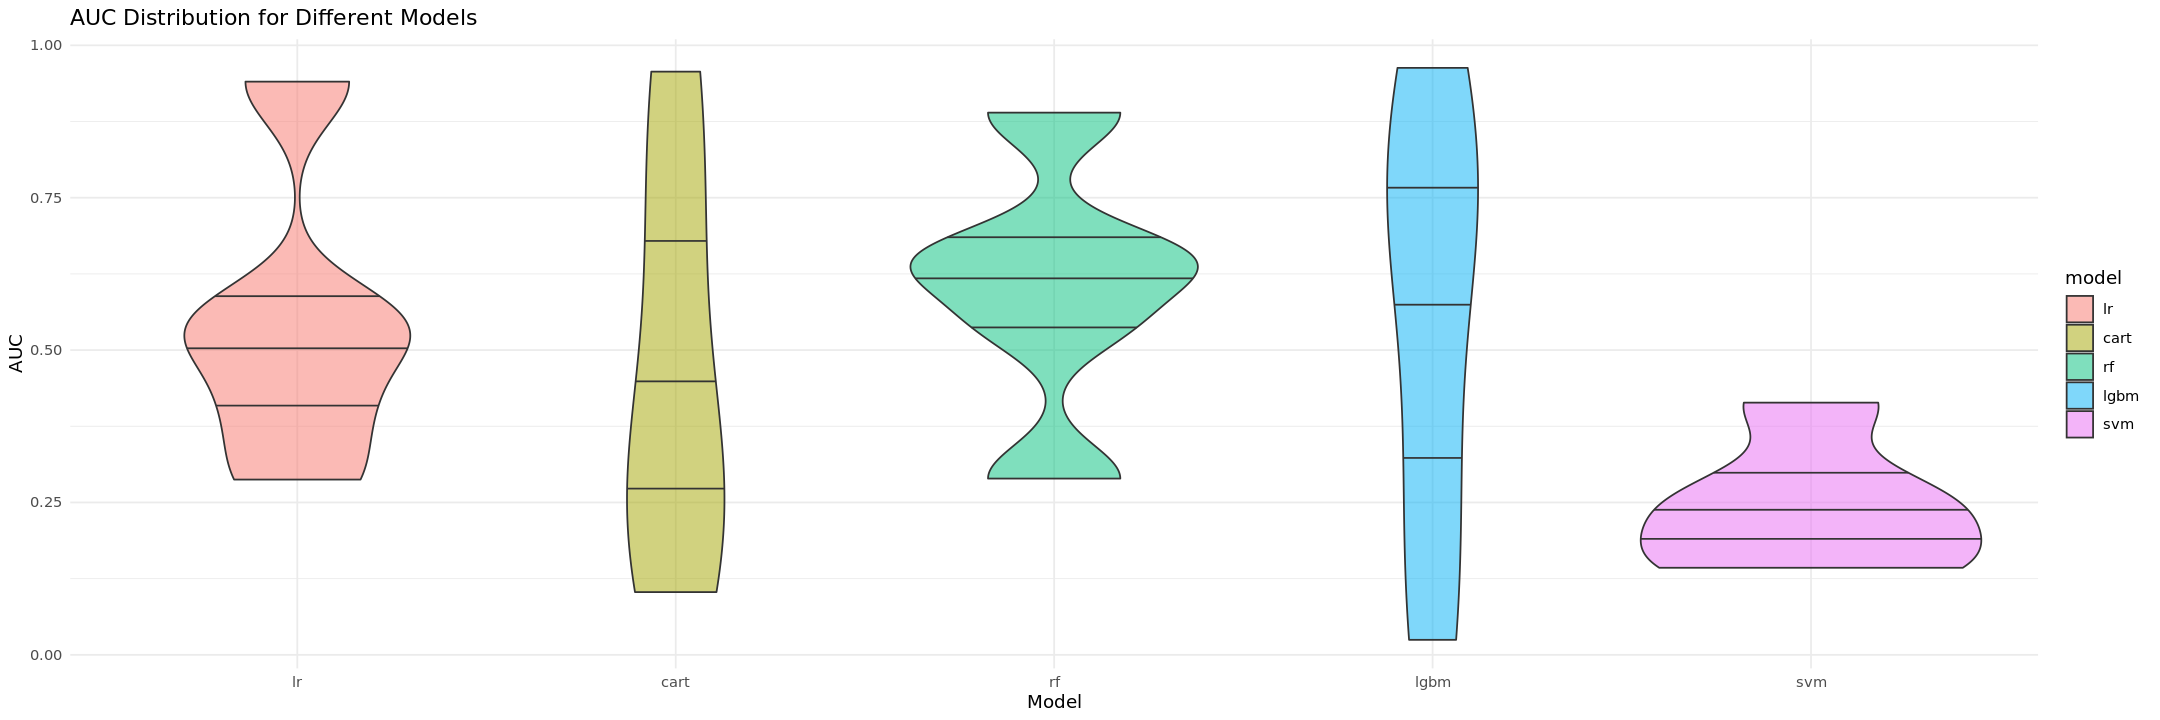

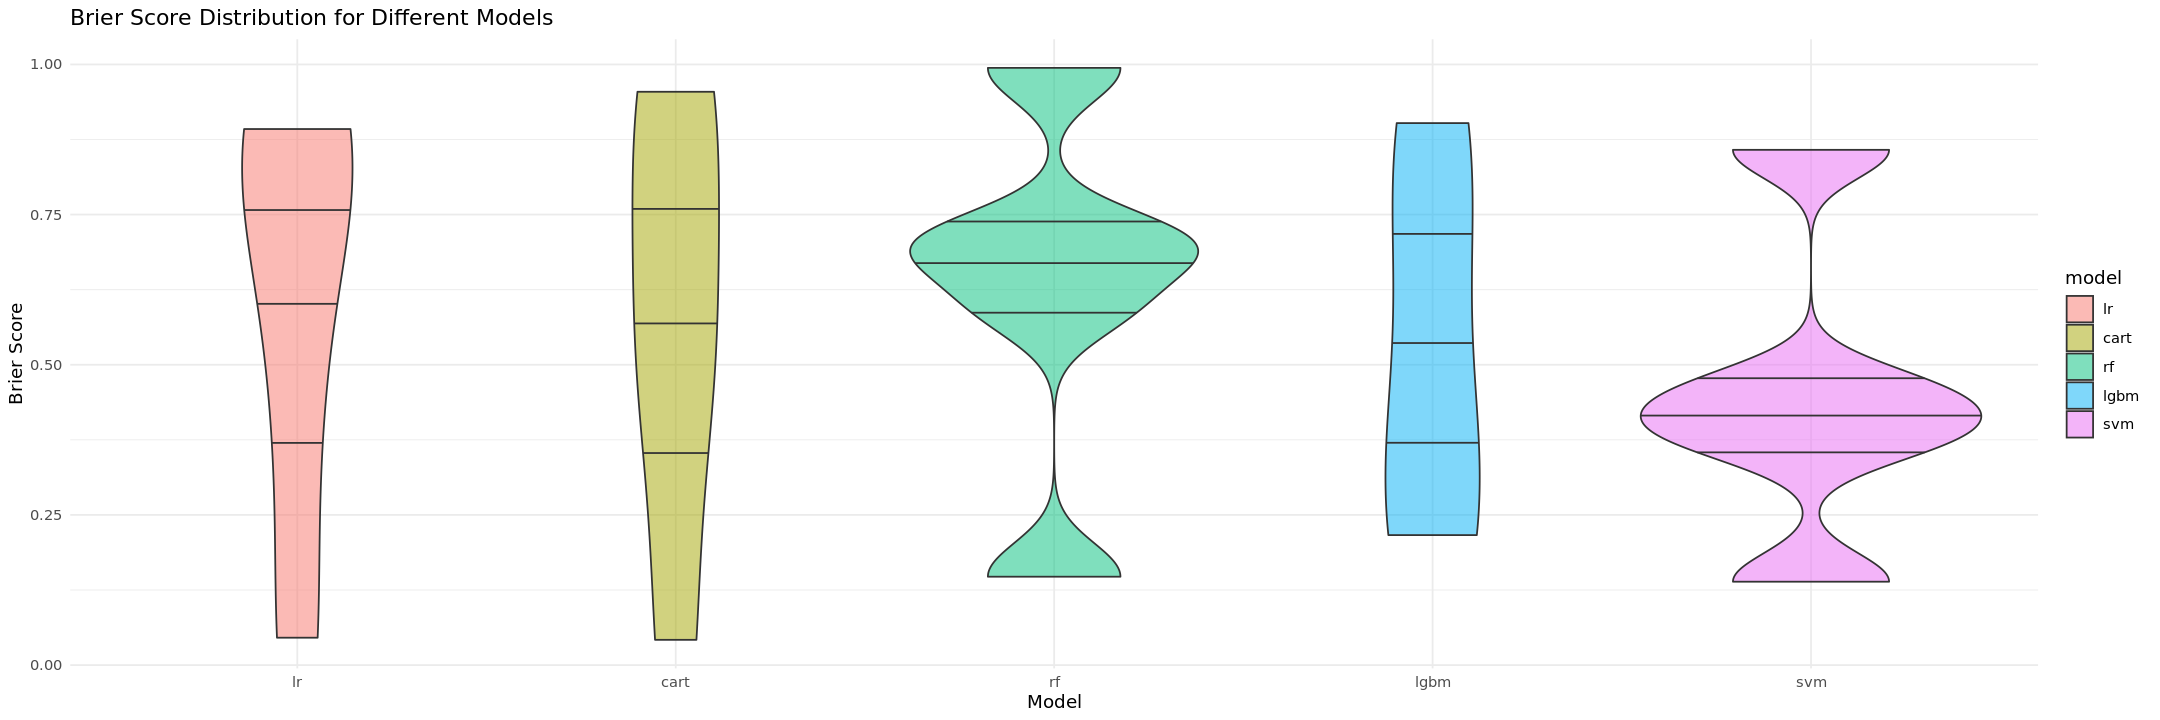

In [74]:
# Do whatever you need to determine which is your best model.
library(ggplot2)
library(tidyr)

# Sample Data (Replace this with your actual data frame)
set.seed(123)
res.cv.df1 <- data.frame(
  type = rep("nested cv", each = 10),
  metric = rep(c("auc", "brier"), times = 5),
  lr = runif(10),
  cart = runif(10),
  rf = runif(10),
  lgbm = runif(10),
  svm = runif(10)
)

# Extract AUC and Brier scores for each model
auc_results <- res.cv.df1[res.cv.df1$metric == "auc", ]
brier_results <- res.cv.df1[res.cv.df1$metric == "brier", ]

# Combine AUC results
auc.df1 <- rbind(auc_results %>% filter(metric == "auc"))

# Pivot the dataframe from wide to long for plotting
auc.df1.long <- auc.df1 %>% 
  tidyr::pivot_longer(-c(type, metric), 
                      names_to = "model",
                      values_to = "auc")
auc.df1.long$model <- factor(auc.df1.long$model, 
                             levels = c("lr", "cart", "rf", "lgbm", "svm"))
auc.df1.long$type <- factor(auc.df1.long$type, 
                            levels = c("nested cv"))

# Plot the violin plot for AUC
ggplot(auc.df1.long, aes(model, auc, fill = model)) + 
  geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75)) + 
  labs(title = "AUC Distribution for Different Models",
       x = "Model", y = "AUC") +
  theme_minimal()

# Combine Brier results
brier.df1 <- rbind(brier_results %>% filter(metric == "brier"))

# Pivot the dataframe from wide to long for plotting
brier.df1.long <- brier.df1 %>% 
  tidyr::pivot_longer(-c(type, metric), 
                      names_to = "model",
                      values_to = "brier")
brier.df1.long$model <- factor(brier.df1.long$model, 
                               levels = c("lr", "cart", "rf", "lgbm", "svm"))
brier.df1.long$type <- factor(brier.df1.long$type, 
                              levels = c("nested cv"))

# Plot the violin plot for Brier Score
ggplot(brier.df1.long, aes(model, brier, fill = model)) + 
  geom_violin(alpha = 0.5, draw_quantiles = c(0.25, 0.5, 0.75)) + 
  labs(title = "Brier Score Distribution for Different Models",
       x = "Model", y = "Brier Score") +
  theme_minimal()


## Question 3: Explainability

### Question 3.1: Feature importance: permute and predict

Identify the most important 3 variables using permute and predict. Using "Lecture 9 - Variable importance on COVID.ipynb" as your reference.

__Question:__ based on your results below, what are the 3 most important variables?

Your answer:

In [93]:
# load your best model for the question below
best_model <- readRDS("final.model.SamiAbdul_svm.rds") # load the model file


In [100]:
# permute and predict based on your best model

library(lightgbm)
library(dplyr)

# Get baseline AUC
preds <- predict(best_model, full_data)
y_true <- full_data[, voutcome]
baseline <- sdgm::auc(preds, x_true)


ERROR: Error in eval(expr, envir, enclos): object 'x_true' not found


In [ ]:
# Permute and predict for variable importance
library(lightgbm)
library(dplyr)

full_data <- sdgm::oncovid
voutcome <- "case_status"

# Train a model with optimal hyperparameters
best_model <- sdgm::lgbm.bestmodel.bin(full_data, voutcome, tune = FALSE)

# Get baseline AUC
preds <- predict(best_model, full_data)
y_true <- full_data[, voutcome]
baseline <- sdgm::auc(preds, y_true)

predictors <- full_data %>% select(-all_of(voutcome)) %>% names

# Permute and predict for variable importance
imp <- sapply(predictors, function(var) {
  mean(sapply(seq(10), function(i) {
    full_data_perm <- full_data
    full_data_perm[, var] <- sample(full_data_perm[, var])
    preds_perm <- predict(best_model, full_data_perm)
    y_true_perm <- full_data_perm[, voutcome]
    
    # Check if lengths match
    if (length(preds_perm) != length(y_true_perm)) {
      warning("Lengths of preds_perm and y_true_perm do not match.")
      return(NA)
    }
    
    baseline - sdgm::auc(preds_perm, y_true_perm)
  }))
})

# Create a data frame with variable names and importance
results <- data.frame(variables = predictors, importance = imp)

# Remove rows with NA importance values
results <- na.omit(results)

# Print the top variables with their importance scores
top_vars <- results[order(results$importance, decreasing = TRUE), ]
print(top_vars)


In [97]:
best_model$importance

ERROR: Error in best_model$importance: $ operator is invalid for atomic vectors


### Question 3.2: Partial Dependence Plot (PDP)

For the most important 3 variables you identified in question 6, plot their functional relationship with the output. Using "Lecture 9 - PDP and fairness examples using sdgm.ipynb" for your reference. 

In [ ]:
# PDP of variable #1
"Your answer"

In [ ]:
# PDP of variable #2
"Your answer"

In [ ]:
# PDP of variable #3
"Your answer"

### Question 3.3

If `drg` is one of your top 3 variables, answer the below question:

What are the top 3 drugs associated with the output, i.e. higher p(1)?

Your answer

## Question 4: Fairness on sex

Refer to "Lecture 9 - PDP and fairness examples using sdgm.ipynb", explore the fairness of your best model on sex.

__Question:__ Do you think your best model is fair to females? Why?

Your answer.

In [ ]:
"Your answer"

## Question 5: Report your results

Check the reporting guideline in the instruction at the top and complete the below table.

In [ ]:
# get the hyperparameters of your best model
best_model$params

In [ ]:
### START CODE HERE  (REPLACE INSTANCES OF "Your answer" with your code) ###  
### Each "Your answer" can be different.
# answer
table <- data.frame(
  my_outcome     = "Your answer",
  my_feature     = "Your answer", # Note you need to paste all predictor names into a string
  n_feature      = "Your answer",
  n_sample         = "Your answer",
  my_model       = "Your answer",
  # for best hyperparameter, I put a space holder for three, 
  # modify it based on your best model.
  best_parameter = paste(paste("Name of hyperparameter 1:", "Your answer", "; "),
                         paste("Name of hyperparameter 2:", "Your answer", "; "),
                         paste("Name of hyperparameter 3:", "Your answer"), sep = ""),
  metric         = "auc",
  eval_results = "Your answer", # AUC value of your best model
  top_3_features = paste("Your answer", "Your answer", "Your answer", sep = "; ")
)

knitr::kable(t(table), "simple")
